<a href="https://colab.research.google.com/github/Raseealmanea/2025_GP_19/blob/main/2025_GP_19/Ouwn_Model/DataPreprocessing/files%20/plm_icd_lr3e_5_NER3/plm_icd_lr3e_5_NER3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thirs Model

The third model used the same learning rate of 3e-5 and was trained for 10 epochs, similar to the second configuration. However, the key difference is that this model incorporated a Medical Named Entity Recognition (Medical-NER) preprocessing step before training. By identifying clinically relevant entities—such as diagnoses, symptoms, procedures, and medications—Medical-NER enriches the input text with structured semantic information. This allows the model to focus on the most important clinical concepts within each note, reduces noise from irrelevant text, and can enhance the model’s ability to map notes to the correct ICD codes. As a result, this configuration aims to improve feature extraction and coding accuracy compared to models trained on raw, unstructured text.

In [1]:
from google.colab import drive
drive.mount('/content/drive') #connect to google drive

import os
os.chdir("/content/drive/MyDrive/medical-coding-reproducibility-main")

Mounted at /content/drive


## Installation

In [23]:
!pip install transformers accelerate tqdm pandas torch


In [24]:
!pip install --no-cache-dir \
  transformers==4.57.1 tokenizers==0.22.1 \
  huggingface-hub==0.36.0 accelerate==1.11.0 safetensors==0.6.2

In [25]:
!PYTHONPATH=/content/coding_env python -c "import numpy, pandas, torch; \
print('NumPy', numpy.__version__); \
print('Pandas', pandas.__version__); \
print('Torch', torch.__version__); \
print('CUDA', torch.cuda.is_available())"

NumPy 2.0.2
Pandas 2.2.2
Torch 2.9.0+cu126
CUDA True


In [26]:
%pip install -q --upgrade pip
%pip install -q "pandas>=2.2,<2.3" "pyarrow>=14,<18" "omegaconf==2.3.0" wget

In [21]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 128.4 MB/s  0:00:00


In [27]:
!pip install hydra-core --upgrade

In [28]:
!pip install "hydra-core==1.3.2" "omegaconf==2.3.0" \
             "pytorch-lightning==2.3.3"  \
             "accelerate>=0.31" "datasets>=2.19" "sentencepiece"

In [ ]:
!pip install --no-cache-dir -U wandb


#Medical NER Preprocessing
We applied a Medical Named Entity Recognition (NER) preprocessing step using the blaze999/Medical-NER model to extract medically relevant concepts from each clinical note. The script loads the original dataset, runs the NER model on the text column, and collects the detected medical entities (e.g., diseases, symptoms, body parts, medications). These extracted entities are cleaned, concatenated, and saved as a new column called ner_clean_text in the same Feather file. This helps reduce noise in the notes and provides a more focused, medically meaningful input that can be optionally used for downstream ICD coding model training.

In [ ]:
%%writefile ner_preprocess.py
import torch
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

MODEL_NAME = "blaze999/Medical-NER"
DATA_DIR = "/content/drive/MyDrive/medcode_data/mimiciv_icd10"
FILE_NAME = "mimiciv_icd10.feather"
TEXT_COLUMN = "text"                         # whatever the current text column is
NEW_COLUMN = "ner_clean_text"               # will be added


INPUT_PATH = f"{DATA_DIR}/{FILE_NAME}"


def load_ner_pipeline():
    device = 0 if torch.cuda.is_available() else -1
    print(f"Loading NER model on device={device} ...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

    return pipeline(
        "token-classification",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="simple",
        device=device,
    )


def clean_word(word: str) -> str:
    for p in ("##", "▁", "Ġ"):
        if word.startswith(p):
            word = word[len(p):]
    return word


def extract_entities(ner_pipe, text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return ""
    try:
        ents = ner_pipe(text)
    except Exception as e:
        print("NER error:", e)
        return ""
    words = [clean_word(e.get("word", "")) for e in ents if clean_word(e.get("word", ""))]
    return " ".join(words)


def main():
    print(f"Loading data from {INPUT_PATH}")
    df = pd.read_feather(INPUT_PATH)

    if TEXT_COLUMN not in df.columns:
        raise ValueError(f"{TEXT_COLUMN} not found. Available: {df.columns}")

    ner_pipe = load_ner_pipeline()

    clean_texts = []
    print("Running Medical-NER over notes...")
    for txt in tqdm(df[TEXT_COLUMN].tolist()):
        clean_texts.append(extract_entities(ner_pipe, txt))

    df[NEW_COLUMN] = clean_texts

    # overwrite the same file (just adds a column)
    df.to_feather(INPUT_PATH)
    print(f"Saved back to {INPUT_PATH} with new column '{NEW_COLUMN}'")
    print(df[[TEXT_COLUMN, NEW_COLUMN]].head())


if __name__ == "__main__":
    main()


Overwriting ner_preprocess.py


In [ ]:
!python ner_preprocess.py

2025-11-20 16:38:43.482814: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 16:38:43.500052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763656723.521134    3628 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763656723.527522    3628 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763656723.543894    3628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Running the experimant

In [ ]:
!python -u main.py \
  experiment=mimiciv_icd10/plm_icd \
  gpu=0 \
  callbacks=defaults \
  trainer.print_metrics=true \
  +trainer.accelerator=gpu \
  +trainer.devices=1 \
  trainer.epochs=10 \
  +optimizer.value.configs.lr=3e-5 \
  name=plm_icd_lr3e-5_NER3

2025-11-24 04:16:33.739726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 04:16:33.757622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763957793.779000    7673 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763957793.785442    7673 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763957793.801885    7673 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# **Outcomes of Third Model**

### Starting with connecting to W&B to retrieve outcome

In [43]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

api = wandb.Api()
run = api.run("raseel25-m-king-saud-university/automatic-medical-coding/twex4tqr")

# Get full history
df = run.history()
print(df.columns.tolist()[:50])

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Currently logged in as: raseel25-m (raseel25-m-king-saud-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


['train.all.recall@10', 'gradients/roberta.encoder.layer.11.attention.output.dense.bias', 'val.icd10_diag.precision@5', 'gradients/roberta.encoder.layer.8.output.dense.bias', 'gradients/roberta.encoder.layer.0.attention.self.value.weight', 'train_val.icd10_proc.map', 'gradients/roberta.encoder.layer.8.attention.self.value.bias', 'test.all.precision@15', 'val.icd10_diag.loss', 'gradients/attention.third_linear.weight', 'gradients/roberta.encoder.layer.10.output.LayerNorm.bias', 'test.icd10_diag.recall@15', 'gradients/roberta.encoder.layer.8.attention.self.key.weight', 'gradients/roberta.encoder.layer.1.output.dense.weight', '_runtime', 'gradients/roberta.embeddings.LayerNorm.weight', 'gradients/roberta.encoder.layer.3.intermediate.dense.weight', 'train.all.precision_macro', 'train_val.all.precision@8', 'gradients/roberta.encoder.layer.5.output.LayerNorm.bias', 'gradients/roberta.encoder.layer.11.output.dense.bias', 'gradients/roberta.encoder.layer.4.output.LayerNorm.weight', 'train_val.

In [44]:
df = run.history()

train_loss = df["train.all.loss"].dropna()
val_loss = df["val.all.loss"].dropna()

# Match lengths (in case one has more points)
min_len = min(len(train_loss), len(val_loss))
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]

epochs = range(1, min_len + 1)


### 1- Training vs Validation Loss
The model demonstrated excellent performance, as shown by the consistently low training and validation losses with no signs of overfitting. Its strong generalization is further confirmed by the high test results, achieving an AUC-Micro of 0.9816 and an AUC-Macro of 0.922. These scores indicate that the model predicts common ICD codes very accurately while also performing well on rare codes, making it highly reliable for real clinical text classification.

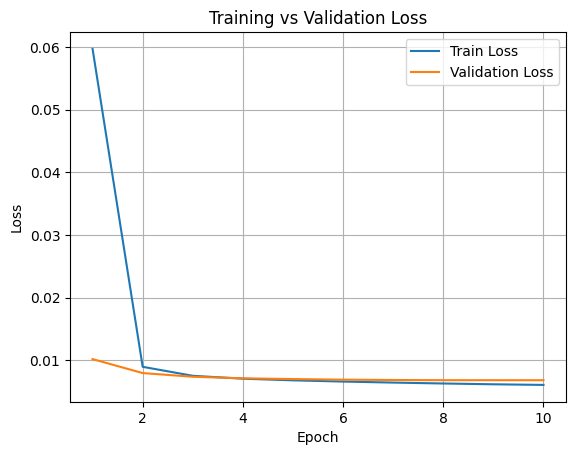

In [45]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Micro F1 Score for All, Diagnosis, and Procedure Across Splits
as shown in the bar graph illustrates the micro F1 performance across the training, validation, and testing splits for all ICD codes, diagnosis codes, and procedure codes. The testing split demonstrates the strongest results, with micro F1 scores of 0.431 for all codes, 0.434 for diagnosis, and 0.423 for procedure codes, indicating good generalization to unseen data. Training scores are slightly lower but consistent, while validation scores are expectedly lower. Overall, the model shows stable and reliable performance across all splits and code categories.

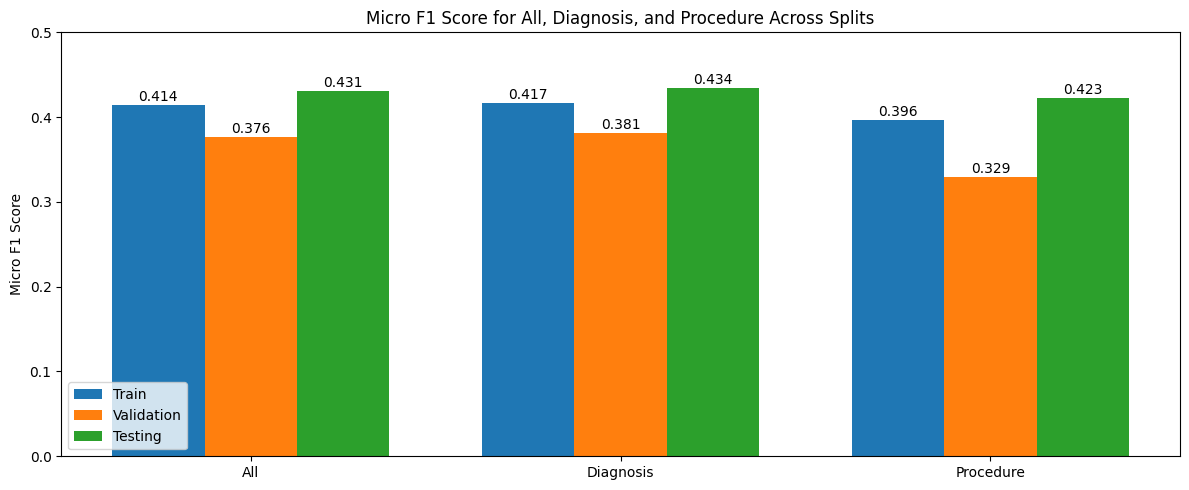

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Given metrics
train = [
    0.4144478440284729,      # train_val.all.f1_micro
    0.4168550372123718,      # train_val.icd10_diag.f1_micro
    0.3963567018508911       # train_val.icd10_proc.f1_micro
]

val = [
    0.37610235810279846,     # val.all.f1_micro
    0.3814651668071747,      # val.icd10_diag.f1_micro
    0.3291342854499817       # val.icd10_proc.f1_micro
]

test = [
    0.4309796392917633,      # test.all.f1_micro
    0.434176504611969,       # test.icd10_diag.f1_micro
    0.42265257239341736      # test.icd10_proc.f1_micro
]

labels = ["All", "Diagnosis", "Procedure"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12,5))
plt.bar(x - width, train, width, label="Train")
plt.bar(x, val, width, label="Validation")
plt.bar(x + width, test, width, label="Testing")

plt.ylabel("Micro F1 Score")
plt.title("Micro F1 Score for All, Diagnosis, and Procedure Across Splits")
plt.xticks(x, labels)

# Add value labels
for i in range(len(labels)):
    plt.text(x[i] - width, train[i] + 0.005, f"{train[i]:.3f}", ha='center')
    plt.text(x[i], val[i] + 0.005, f"{val[i]:.3f}", ha='center')
    plt.text(x[i] + width, test[i] + 0.005, f"{test[i]:.3f}", ha='center')

plt.ylim(0, 0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Macro F1 Scores Across Splits (All, Diagnosis, Procedure)
The macro F1 comparison as shown highlights the challenge of predicting ICD-10 codes uniformly across all classes. While the testing split achieves the highest scores—0.102 for all codes, 0.106 for diagnosis codes, and 0.095 for procedure codes—both training and validation scores remain lower, especially for procedure codes. This pattern reflects the high class imbalance and the large number of rare ICD codes, which make macro-F1 inherently difficult to optimize. Despite this, the model consistently performs best on unseen test data, demonstrating strong generalization even under imbalanced conditions.

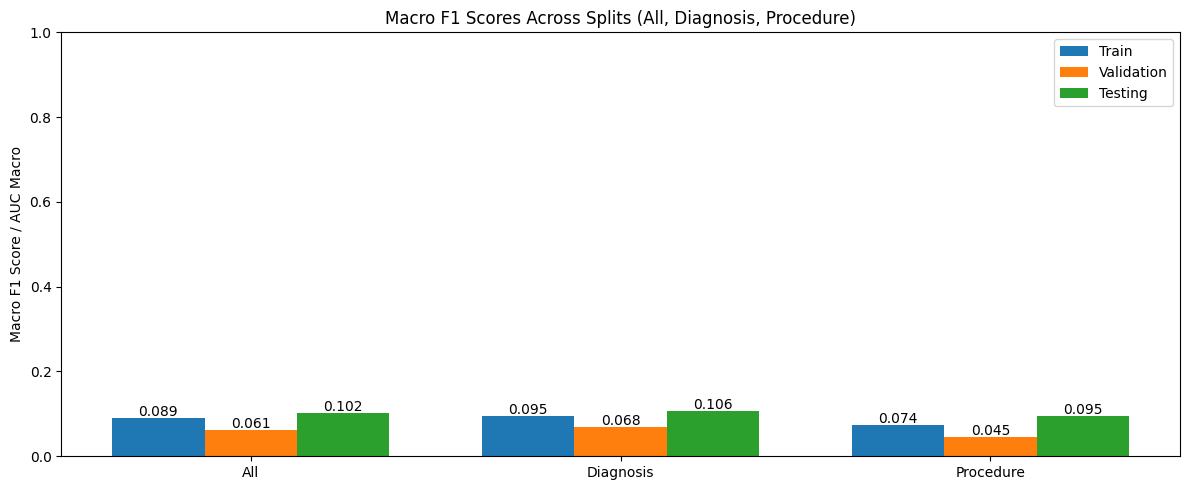

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Provided macro F1 metrics
train = [
    0.0892285406589508,       # train_val.all.f1_macro
    0.0951288491487503,       # train_val.icd10_diag.f1_macro
    0.0743570402264595        # train_val.icd10_proc.f1_macro
]

val = [
    0.06148960441350937,      # val.all.f1_macro
    0.06831278651952744,      # val.icd10_diag.f1_macro
    0.04453577846288681       # val.icd10_proc.f1_macro
]

test = [
    0.10192596912384032,
    0.10644806921482086,      # test.icd10_diag.f1_macro
    0.09520532935857771       # test.icd10_proc.f1_macro
]

labels = ["All", "Diagnosis", "Procedure"]
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12,5))
plt.bar(x - width, train, width, label="Train")
plt.bar(x, val, width, label="Validation")
plt.bar(x + width, test, width, label="Testing")

plt.ylabel("Macro F1 Score / AUC Macro")
plt.title("Macro F1 Scores Across Splits (All, Diagnosis, Procedure)")
plt.xticks(x, labels)

# Add numeric labels
for i in range(len(labels)):
    plt.text(x[i] - width, train[i] + 0.005, f"{train[i]:.3f}", ha='center')
    plt.text(x[i], val[i] + 0.005, f"{val[i]:.3f}", ha='center')
    plt.text(x[i] + width, test[i] + 0.005, f"{test[i]:.3f}", ha='center')

plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


### Precision@k for All, Diagnosis, and Procedure Across Splits
The Precision@k results demonstrate that the model performs consistently well for both All ICD codes and Diagnosis codes across all splits, with Precision@5 values around 0.63–0.66. Performance decreases as k increases from 5 to 15, which is expected since more predictions reduce precision.

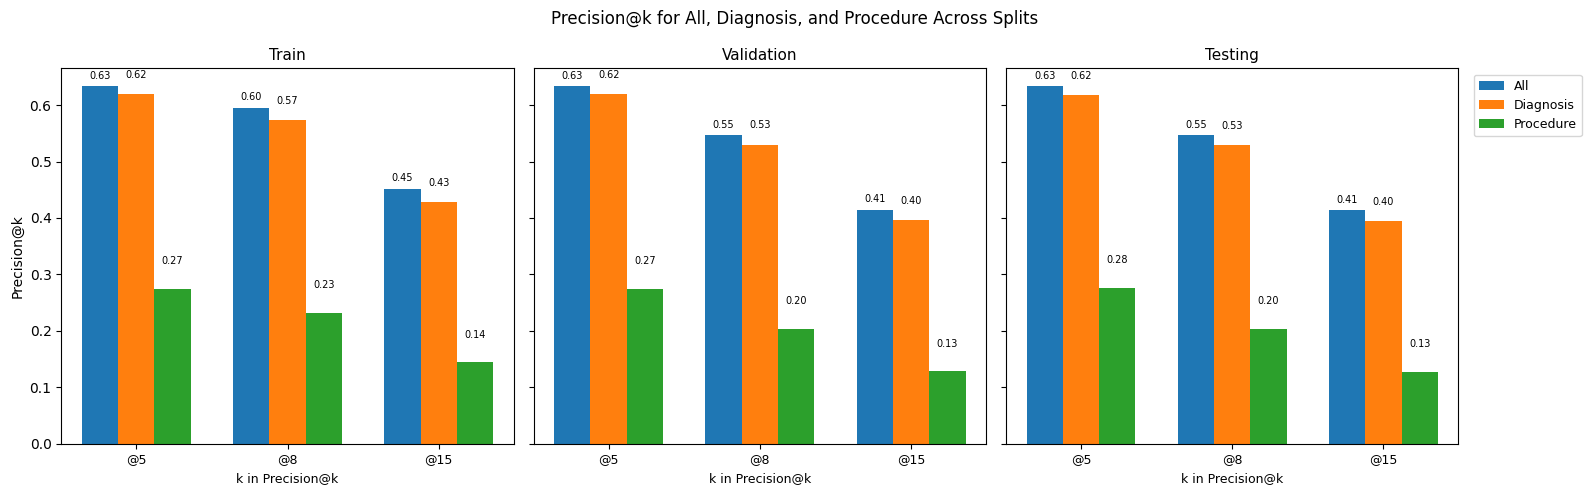

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Precision values
train_val = {
    "@5":  [0.6334486603736877, 0.619691789150238, 0.2749846875667572],
    "@8":  [0.5951274633407593, 0.5728974938392639, 0.23184047639369965],
    "@15": [0.4517802596092224, 0.42883333563804626, 0.14416861534118652],
}

val = {
    "@5":  [0.6334486603736877, 0.619691789150238, 0.2749846875667572],
    "@8":  [0.5465971827507019, 0.530028760433197, 0.20336544513702393],
    "@15": [0.4138761758804322, 0.3963359594345093, 0.12799517810344696],
}

test = {
    "@5":  [0.63312673568725559, 0.6172738075256348, 0.2762048542499542],
    "@8":  [0.5461719036102295, 0.5288665294647217, 0.2033846527338028],
    "@15": [0.41368719935417175, 0.3952866196632385, 0.12789270281791687],
}

splits = ["Train", "Validation", "Testing"]
categories = ["All", "Diagnosis", "Procedure"]
k_values = ["@5", "@8", "@15"]
datasets = [train_val, val, test]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, split, data in zip(axes, splits, datasets):
    x = np.arange(len(k_values))
    width = 0.24

    bars_all = ax.bar(x - width, [data[k][0] for k in k_values], width, label="All")
    bars_diag = ax.bar(x, [data[k][1] for k in k_values], width, label="Diagnosis")
    bars_proc = ax.bar(x + width, [data[k][2] for k in k_values], width, label="Procedure")

    # Add labels with smaller font, 2 decimals, and slightly staggered vertically
    for bars, offset in zip([bars_all, bars_diag, bars_proc], [0.01, 0.025, 0.04]):
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + offset,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=7,
                rotation=0,
            )

    ax.set_title(split, fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(k_values, fontsize=9)
    ax.set_xlabel("k in Precision@k", fontsize=9)

axes[0].set_ylabel("Precision@k", fontsize=10)
fig.suptitle("Precision@k for All, Diagnosis, and Procedure Across Splits", fontsize=12)
axes[-1].legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), fontsize=9)

plt.tight_layout()
plt.show()


### Recall@10 and Recall@15 Across Splits
The Recall@k results in the graph show that the model retrieves procedure codes most effectively, with recall values exceeding 0.73 at k=10 and 0.78 at k=15 across all splits. Diagnosis codes achieve moderate recall, while the overall recall for all codes is slightly lower due to the larger label space. Recall consistently improves when k increases from 10 to 15, indicating that allowing more predicted codes helps the model capture more relevant labels.

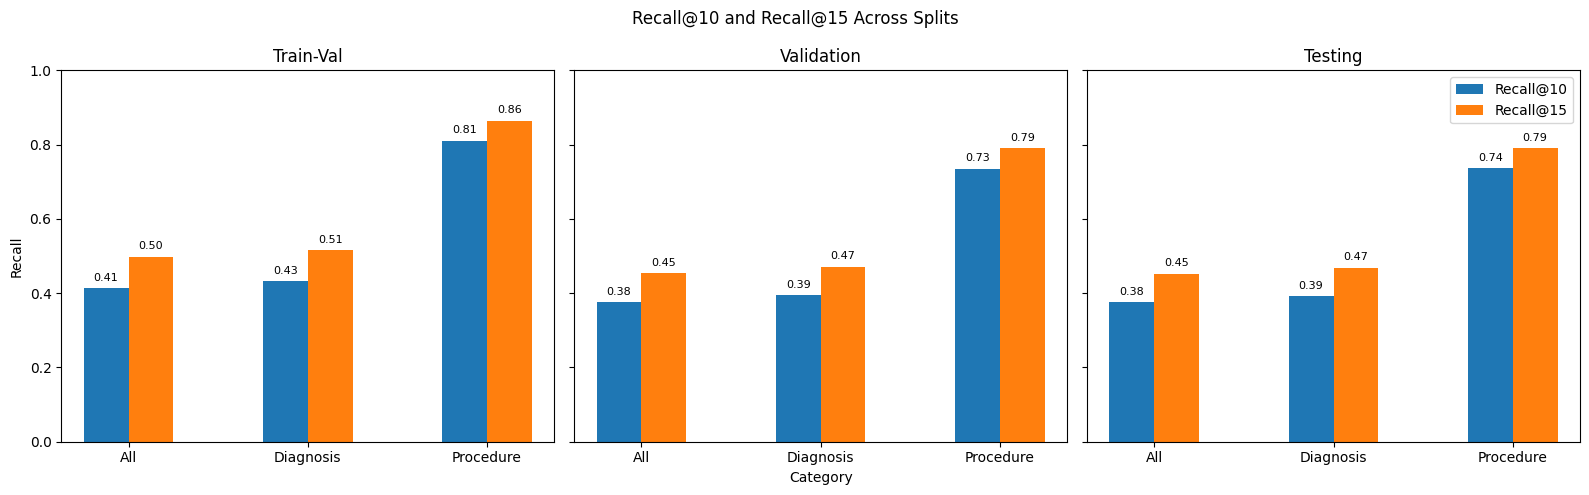

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Data
splits = ["Train-Val", "Validation", "Testing"]
categories = ["All", "Diagnosis", "Procedure"]

recall10 = [
    [0.4140620529651642, 0.4317497909069062, 0.8109830617904663],  # train_val
    [0.3758297562599182, 0.39448684453964233, 0.7347095608711243],  # val
    [0.3750452995300293, 0.3924500644207001, 0.7358669638633728],  # test
]

recall15 = [
    [0.49831676483154297, 0.5148913264274597, 0.8641196489334106],  # train_val
    [0.4532163441181183, 0.47166183590888977, 0.7896106839179993],  # val
    [0.45196333527565, 0.4690283536911011, 0.7904890775680542],  # test
]

x = np.arange(len(categories))
width = 0.25

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, ax in enumerate(axes):
    ax.bar(x - width/2, recall10[i], width, label="Recall@10")
    ax.bar(x + width/2, recall15[i], width, label="Recall@15")
    ax.set_title(splits[i])
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylim(0,1)
    for j in range(3):
        ax.text(j - width/2, recall10[i][j] + 0.02, f"{recall10[i][j]:.2f}", ha='center', fontsize=8)
        ax.text(j + width/2, recall15[i][j] + 0.02, f"{recall15[i][j]:.2f}", ha='center', fontsize=8)

axes[1].set_xlabel("Category")
axes[0].set_ylabel("Recall")
axes[2].legend()

plt.suptitle("Recall@10 and Recall@15 Across Splits")
plt.tight_layout()
plt.show()
